In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [2]:
df = pd.read_csv("../../../../main/sub_data/single_variant/mode/train/train_mode.csv",index_col="Date",parse_dates=True)
df_test = pd.read_csv("../../../../main/sub_data/single_variant/mode/test/test_mode.csv",index_col="Date",parse_dates=True)

In [3]:
df

,Max.Demand met during the day (MW)
Date,
2013-04-01,2776.0
2013-04-02,3034.0
2013-04-03,2991.0
2013-04-04,3125.0
2013-04-05,3160.0
...,...
2023-04-26,4445.0
2023-04-27,4626.0
2023-04-28,4395.0


## Transforming Data
    
    The Steps adopted for Transformation are
<ul>
    <li>Rolling Window</li>
    <li>Outliers Replacement</li>
</ul>

In [4]:
# We use Aggregate method (for this, we need a function)
def percent_change(series):
    prev = series[:-1]
    last = series[-1:]
    change = (last-np.sum(prev))/np.sum(prev)
    return change

def replace_outliers(series):
    mean_diff = np.abs(series - np.mean(series))
    # Criteria for detecting outliers
    this_mask = mean_diff > (np.std(series) * 3)
    # replace it with median
    series[this_mask] = np.nanmedian(series)
    return series

In [5]:
'''
    Rolling : A rolling window of every size (n) is applied to every column
    After applying an n size NaN Values will be available
    
'''
df_per_ch = df.rolling(10).aggregate(percent_change).dropna()

In [6]:
df_per_ch

,Max.Demand met during the day (MW)
Date,
2013-04-10,-0.879993
2013-04-11,-0.875218
2013-04-12,-0.878073
2013-04-13,-0.879480
2013-04-14,-0.893184
...,...
2023-04-26,-0.893719
2023-04-27,-0.887743
2023-04-28,-0.891511


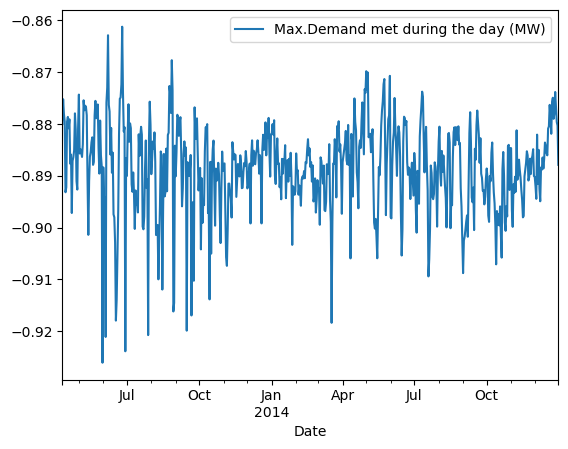

In [7]:
# Now Visualize it
df_per_ch.loc[:"2014"].plot()
plt.show()

In [8]:
df_per_ch = df_per_ch.apply(lambda col : replace_outliers(col))

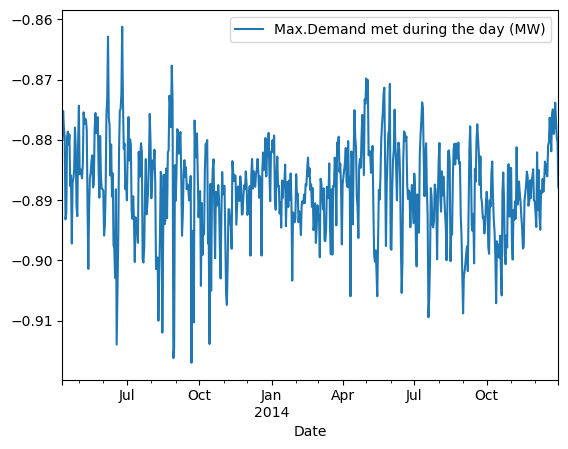

In [9]:
# Now Visualize it
df_per_ch.loc[:"2014"].plot()
plt.show()

In [10]:
features_basic = df_per_ch.rolling(7,min_periods=5, closed='right').aggregate([np.max,np.min,np.mean,np.std]).dropna()

In [11]:
df_test1 = df_test.rolling(10).aggregate(percent_change).dropna()
features_basic_test1 = df_test1.rolling(7,min_periods=5, closed='right').aggregate([np.max,np.min,np.mean,np.std]).dropna()
features_basic_test1.dropna()

Max.Demand met during the day (MW)                              
                                         amax      amin      mean       std
Date                                                                       
2023-05-14                          -0.863081 -0.871281 -0.867774  0.003343
2023-05-15                          -0.863081 -0.871281 -0.867105  0.003408
2023-05-16                          -0.863081 -0.871281 -0.867353  0.003179
2023-05-17                          -0.863081 -0.871281 -0.867346  0.003172
2023-05-18                          -0.863081 -0.880159 -0.869069  0.005819
2023-05-19                          -0.863764 -0.885684 -0.872298  0.007857
2023-05-20                          -0.863764 -0.889092 -0.875599  0.009454
2023-05-21                          -0.863764 -0.889092 -0.876714  0.009319
2023-05-22                          -0.868835 -0.889092 -0.877811  0.007882
2023-05-23                          -0.867543 -0.889092 -0.877627  0.008138
2023-05-24                          -0.867543 -0.889092 -0.879532  0.007709
2023-05-25                          -0.867543 -0.895520 -0.881727  0.009815
2023-05-26                          -0.867543 -0.906149 -0.884650  0.013534
2023-05-27                          -0.867543 -0.906149 -0.886699  0.015289
2023-05-28                          -0.867543 -0.907654 -0.890780  0.016669
2023-05-29                          -0.867543 -0.907654 -0.895772  0.015069
2023-05-30                          -0.883720 -0.907654 -0.900909  0.008569
2023-05-31                          -0.895520 -0.909672 -0.904616  0.004577

In [12]:
cols = features_basic.columns
X_train = features_basic
y_train = df.loc["2013-04-14":]
X_test = features_basic_test1.dropna()
y_test = df_test.loc['2023-05-14':]

In [13]:
# Fit the Ridge model
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
MAPE(y_test,y_pred)

0.1778231290178359

In [14]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
MAPE(y_test,y_pred)

0.10302164627522609

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
MAPE(y_pred,y_test)

/Users/sujaykumar/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1332195420468311

In [16]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svr = SVR()
svr.fit(X_train_scaled, y_train)
y_pred = svr.predict(X_test_scaled)
MAPE(y_test,y_pred)

/Users/sujaykumar/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.21381705006054214

## Without Rolling

In [17]:
features_basic_no = df.rolling(7,min_periods=5, closed='right').aggregate([np.max,np.min,np.mean,np.std])

In [18]:
features_basic_no = features_basic_no.dropna()
features_basic_test2 = df_test.rolling(7,min_periods=5, closed='right').aggregate([np.max,np.min,np.mean,np.std])
features_basic_test2.dropna()

Max.Demand met during the day (MW)                                 
                                         amax    amin         mean         std
Date                                                                          
2023-05-05                             3944.0  3607.0  3768.600000  160.840915
2023-05-06                             3944.0  3607.0  3778.166667  145.756532
2023-05-07                             3944.0  3607.0  3783.571429  133.823089
2023-05-08                             4460.0  3670.0  3905.428571  267.670729
2023-05-09                             4518.0  3670.0  4024.857143  330.496308
2023-05-10                             4595.0  3670.0  4117.857143  390.159979
2023-05-11                             4808.0  3816.0  4280.428571  409.076952
2023-05-12                             5145.0  3816.0  4452.571429  487.890649
2023-05-13                             5197.0  3816.0  4648.428571  469.269950
2023-05-14                             5197.0  4460.0  4844.428571  329.285518
2023-05-15                             5661.0  4518.0  5016.000000  400.732662
2023-05-16                             5691.0  4595.0  5183.571429  403.025995
2023-05-17                             5867.0  4808.0  5365.285714  379.494714
2023-05-18                             5867.0  5145.0  5477.428571  293.641424
2023-05-19                             5867.0  5188.0  5522.142857  256.002883
2023-05-20                             5867.0  5188.0  5549.857143  223.356538
2023-05-21                             5948.0  5391.0  5658.428571  201.821586
2023-05-22                             6427.0  5391.0  5767.857143  353.851395
2023-05-23                             6785.0  5391.0  5924.142857  517.841813
2023-05-24                             6785.0  5391.0  5963.428571  523.187939
2023-05-25                             6785.0  5391.0  5960.000000  526.090613
2023-05-26                             6785.0  4991.0  5893.285714  621.346579
2023-05-27                             6785.0  4991.0  5844.714286  677.872828
2023-05-28                             6785.0  4780.0  5677.857143  783.701565
2023-05-29                             6785.0  4780.0  5442.857143  768.103602
2023-05-30                             6142.0  4780.0  5169.428571  506.989434
2023-05-31                             5569.0  4462.0  4929.428571  339.997479

In [19]:
cols = features_basic.columns
X_train_no = features_basic
y_train_no = df.loc['2013-04-05':]
X_test_no = features_basic_test2.dropna()
y_test_no =df_test.loc['2023-05-05':]

In [20]:
# Fit the Ridge model
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
MAPE(y_test,y_pred)

0.1778231290178359

In [21]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
MAPE(y_test,y_pred)

0.10302164627522609

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
MAPE(y_pred,y_test)

/Users/sujaykumar/miniconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.13617749701023182

In [23]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svr = SVR()
svr.fit(X_train_scaled, y_train)
y_pred = svr.predict(X_test_scaled)
MAPE(y_test,y_pred)

/Users/sujaykumar/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.21381705006054214